# Analyse the optimal KdV solutions

## TODO

 - Get a time series of $a_0$
 - Plot the results in $L_s/L - A_{max}/a_0$ space 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py


from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV



import matplotlib as mpl

import yaml

In [2]:
%matplotlib notebook

In [17]:
    # Load the csv file with the representative beta's and target A_max
outfilestr = '../../kdv_solutions_magnus/a0_optimize/ekdv_optimal_a0_Prelude'
outcsvfile = '../data/ekdv_Prelude_results.csv'
csvfile = '../data/vkdv_inputs_prelude.csv'
x_pt = 101500

#csvfile = '../data/vkdv_inputs_imospil200.csv'
#outfilestr = '../data/ekdv_optimal_a0_PILIMOS'
#outcsvfile = '../data/ekdv_PILIMOS_results.csv'
#x_pt = 53500


#csvfile = '../data/vkdv_inputs_mode2_imospil200.csv'
#outfilestr = '../data/kdv_mode2_optimal_a0_PILIMOS'
#outcsvfile = '../data/kdv_mode2_PILIMOS_results.csv'
#x_pt = 53500



#pd.read_csv?
data = pd.read_csv(csvfile, sep=', ', parse_dates=['time','timemax'], index_col='time')

data.head()

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,timemax,Amax,beta0,beta1,beta2,beta3,beta4,beta5
time,,,,,,,,
2016-05-01,2016-05-01 22:49:00,-17.517,1023.464,1.281,59.462,25.583,83.175,44.421
2016-05-02,2016-05-02 17:26:00,-16.563,1023.489,1.281,59.431,27.549,84.906,47.735
2016-05-03,2016-05-03 20:50:00,19.584,1023.489,1.281,59.800,26.636,84.889,50.688
2016-05-04,2016-05-04 23:28:00,25.726,1023.505,1.283,59.814,27.861,86.798,53.998
2016-05-05,2016-05-05 18:50:00,-26.879,1023.528,1.282,60.298,29.466,86.836,56.151


In [168]:
# Test for computing the time of maximum
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        bidx = (amp_signal>=amp_min) & (amp_signal<= amp_min -0.01*amp_min)
        idx = np.argwhere(bidx)
        return amp_min, idx[0][0]
    else:
        bidx = (amp_signal<=amp_max) & (amp_signal>= amp_max -0.01*amp_max)
        idx = np.argwhere(bidx)
        return amp_max, idx[0][0]
    
#ds.B_pt.plot()
#Amax, tidx = maximum_amplitude_finder(ds.B_pt.values)
#print(Amax, ds.timefast.values[tidx])

In [169]:
a0 = []
Amax = []
Tmax = []
Ls = []
Ls_x = []
C_x = []
alpha_x = []
beta_x = []
C_mu = []
alpha_mu = []
beta_mu = []
alpha_w = []
time = []

for tt,tnow in enumerate(data.index):
    outfile = '%s_%s.nc'%(outfilestr,tnow.strftime('%Y-%m-%d'))
    try:
        ds = xr.open_dataset(outfile)
    except:
        continue
    #print(outfile)
    
    a0.append(ds.a0)
    #Amax.append(ds.Amax)
    time.append(tnow)
    
    Amax_now, tidx = maximum_amplitude_finder(ds.B_pt.values)
    Tmax.append(ds.timefast.values[tidx])
    Amax.append(Amax_now)
    
    
    # Calculate mean quantities
    dx = ds.x.values[1]-ds.x.values[0]
    nx = ds.x.shape[0]
    L = np.arange(1,nx+1,1)*dx
    #L = 0.5*(Lend[1::] + Lend[0:-1])

    C_mu_t = np.cumsum(ds.Cn.values*dx) / L
    alpha_mu_t = np.cumsum(ds.Alpha.values*dx) / L

    Q_x = np.gradient(ds.Qterm.values,dx)
    beta = 0.5/ds.Qterm.values * Q_x
    beta_mu_t = np.cumsum(beta*dx) / L

    # Steepening length scale - using global values
    omega = 2*np.pi/(12.42*3600)
    c2 = C_mu_t*C_mu_t
    Ls_x_t = -c2 / (ds.a0* (alpha_mu_t*omega))# + c2*beta_mu))
    
    # Compute weights for "Ls - weighted alpha"
    Ls_inv = 1. / Ls_x_t
    w = Ls_inv / np.sum(Ls_inv) * L
    
    
    # Steepening length using local values (for testing...)
    omega = 2*np.pi/(12.42*3600)
    c2 = ds.Cn.values*ds.Cn.values
    Ls_x_local = -c2 / (ds.a0* (ds.Alpha.values))#*omega + c2*beta))
    
    idx = np.argwhere(ds.x.values>x_pt)[0,0]
    
    alpha_x.append(ds.Alpha.values[idx])
    C_x.append(ds.Cn.values[idx])
    
    Ls.append(Ls_x_t[idx])
    Ls_x.append(Ls_x_local[idx])
    
    C_mu.append(C_mu_t[idx])
    alpha_mu.append(alpha_mu_t[idx])
    
    alpha_w_tmp = np.cumsum(ds.Alpha.values*w*dx) / L
    alpha_w.append(alpha_w_tmp[idx])
    #break
    
a0 = np.array(a0)
Amax = np.array(Amax)
Tmax = np.array(Tmax)

Ls = np.array(Ls)
C_x = np.array(C_x)
alpha_x = np.array(alpha_x)
C_mu = np.array(C_mu)
alpha_mu = np.array(alpha_mu)
alpha_w = np.array(alpha_w)
Ls_l = np.array(Ls_l)
time=np.array(time)

-16.353138210973867 4852 4932
-16.40931025379359 4883 4964
-19.65448069369646 4846 4858
-25.708935223947794 7595 7597
-26.884515894165958 7607 7608
-30.712300635614454 7610 7611
-30.74631436719662 7671 7672
-31.709843922418482 7693 7694
-29.392052214446196 7685 7687
-31.115188606268116 7625 7626
-29.799981936531648 7530 7532
-32.157979576802504 7777 7852
-30.467450382554485 4890 4912
-26.78527614073722 4901 4923
-22.888243169832684 4926 4950
-21.943008751889504 4928 4952
-23.76580166645806 4913 4936
-20.43713723816925 4915 4939
-22.359369558494304 4908 4930
-18.526127640631252 4913 4937
-19.57906117356285 4910 4933
-17.668340305439965 4912 4936
-19.28515913101062 4913 4936
-16.685517414147515 4931 4955
-17.306821591894675 4930 4954
-15.052673137919525 4925 4950
-17.039231335381597 4896 4918
-20.162489046684236 4878 4899
-16.06207718297554 4900 4923
-13.509532270027629 4895 4920
-16.65987567748978 4868 4891
-19.100018839155865 4853 4874
-20.31372231825646 4867 4888
-25.48338311372001 48

-18.23127624579327 5033 5121
-25.985675738176884 5006 7973
-29.895338229835907 7697 7700
-33.484866348608726 7706 7709
-39.40857058390452 7715 7717
-46.18303432108283 7723 7725
-52.27487686747097 7751 7753
-58.17907439082444 7732 7734
-67.74730083877117 7947 7951
-52.35038931991316 7949 7953
-39.85497708678431 7927 7934
-30.90923915801297 4992 5016
-17.625265508762453 5001 5027
-16.172836768598515 5016 5042
-22.702182385065136 4992 5016
-24.40426848571098 5016 5040
-25.215955232681136 4995 5086
-27.189099398711367 5030 5128
-32.03487207949387 7931 8012
-32.583246466058156 7977 7984
-30.357670556305973 4997 5093
-29.63346126052507 4992 5081
-27.643745550509504 5039 5065
-38.452814178560686 7994 8006
-25.288742779618584 5011 5038
-21.365457772443445 5000 5028
-16.623382401532005 5008 5037
-13.957411694925373 5020 5049
-17.19639783828536 5001 5029
-17.302681296573628 5008 5036
-20.20405669249722 5030 5057
-20.3782045915423 5042 5070
-21.233799236821735 5034 5061
-24.49819264792992 5031 50

In [170]:
# Add the new data into the pandas DataFrame
data['a0'] = pd.Series(a0, index=time)
data['Ls'] = pd.Series(Ls, index=time)
data['alpha'] = pd.Series(alpha_x, index=time)
data['C'] = pd.Series(C_x, index=time)
data['alpha_mu'] = pd.Series(alpha_mu, index=time)
data['alpha_w'] = pd.Series(alpha_w, index=time)
data['C_mu'] = pd.Series(C_mu, index=time)
data['Tmax'] = pd.Series(Tmax, index=time)

#data.to_csv(outcsvfile, float_format='%3.4f')
data.shape

(319, 16)

In [171]:
idx = ~np.isnan(data['alpha'].values)
np.polyfit(data['alpha'].values[idx],data['alpha_w'].values[idx],1)


array([ 8.52384758, -0.07010431])

<IPython.core.display.Javascript object>


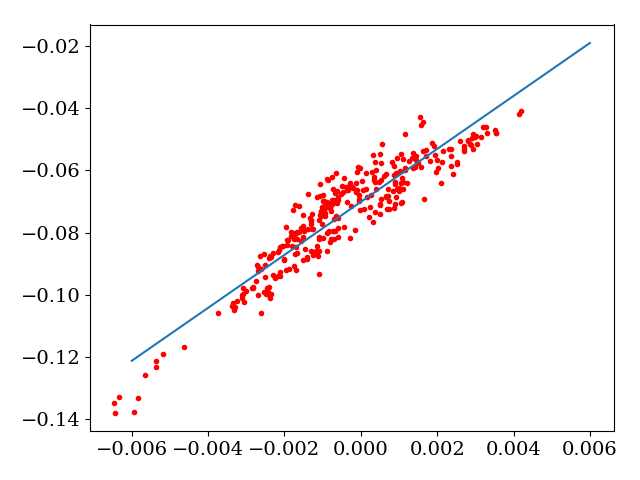

array([ 8.52384758, -0.07010431])

In [172]:
# Compare alpha with the mean
plt.figure()
plt.plot(data['alpha'],data['alpha_w'],'r.')
idx = ~np.isnan(data['alpha'].values)
p=np.polyfit(data['alpha'].values[idx],data['alpha_w'].values[idx],1)
plt.plot(np.linspace(-0.006,0.006,100),np.linspace(-0.006,0.006,100)*p[0] + p[1] )
plt.tight_layout()
p

<IPython.core.display.Javascript object>


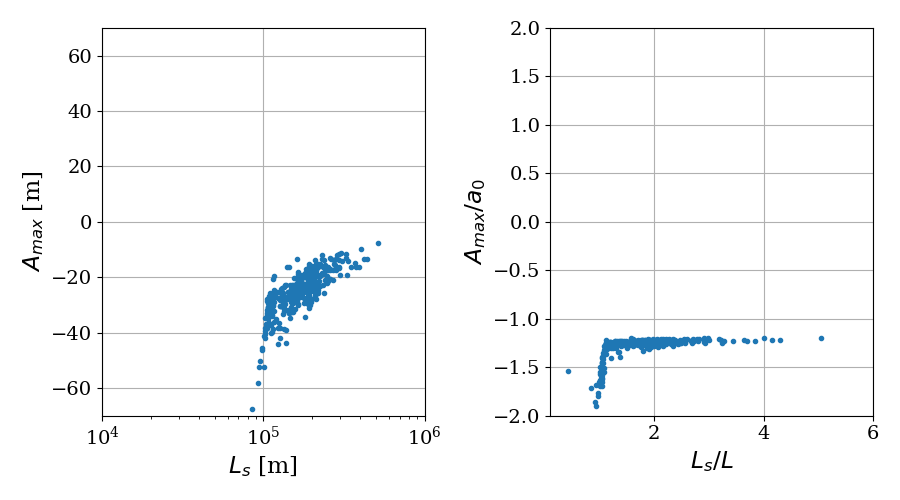

In [173]:
plt.figure(figsize=(9,5))
plt.subplot(122)
#plt.semilogx(Ls/x_pt, Amax/a0, '.')
plt.plot(Ls/x_pt, Amax/a0, '.')

#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(0.1,6)
plt.ylim(-2,2)
plt.xlabel('$L_s/L$')
plt.ylabel('$A_{max}/a_0$')
plt.tight_layout()

plt.subplot(121)

plt.semilogx(Ls, Amax, '.')
#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(1e4,1e6)
plt.ylim(-70,70)
plt.xlabel('$L_s$ [m]')
plt.ylabel('$A_{max}$ [m]')
plt.tight_layout()

<IPython.core.display.Javascript object>


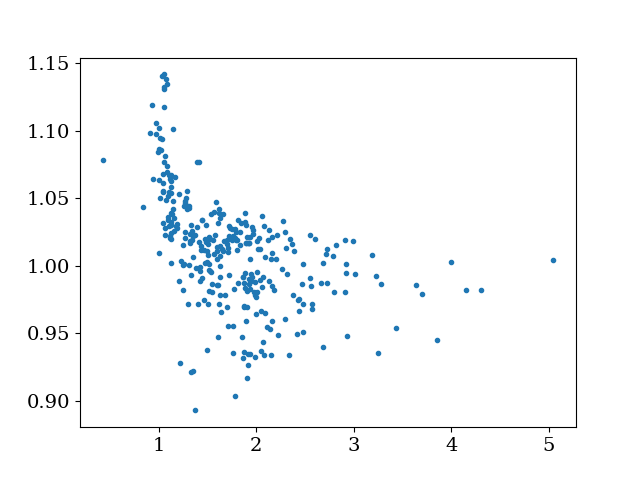

In [174]:
# C_nl = nonlinear propation speed
C_nl = C_x + alpha_x*Amax

plt.figure()
plt.plot(Ls/x_pt , C_nl/C_x,'.')

<IPython.core.display.Javascript object>


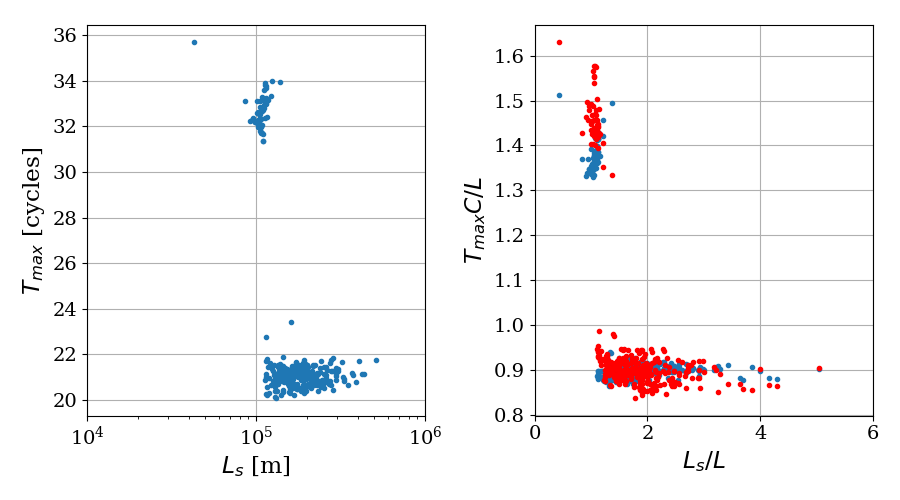

In [175]:
# Clean up Tmax by shifting stuff that is greater than a period out
Tmax_norm = Tmax/(12.42*3600)

#Tmax_norm[Tmax_norm>2] = Tmax_norm[Tmax_norm>2]-1

#Tmax_norm = np.mod(Tmax/(12.42*3600),2)


plt.figure(figsize=(9,5))
plt.subplot(122)
#plt.semilogx(Ls/x_pt, Amax/a0, '.')
plt.plot(Ls/x_pt  ,  (Tmax_norm*C_x/x_pt)*12.42*3600 , '.')
plt.plot(Ls/x_pt  ,  (Tmax_norm*C_nl/x_pt)*12.42*3600 , 'r.')

#plt.plot(Ls/x_pt  , (Tmax*C_x/x_pt) , '.')

#plt.plot(Amax/a0, Tmax*C_x/x_pt, '.')


#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(0.,6)
#plt.ylim(1,1.5)
plt.xlabel('$L_s/L$')
plt.ylabel('$T_{max} C/L$')
plt.tight_layout()

plt.subplot(121)


plt.semilogx(Ls, Tmax/3600, '.')
#plt.semilogx(Ls_l/x_pt, Amax/a0, 'r.')
plt.grid(b=True)
plt.xlim(1e4,1e6)
#plt.ylim(-70,70)
plt.xlabel('$L_s$ [m]')
plt.ylabel('$T_{max}$ [cycles]')
plt.tight_layout()

<IPython.core.display.Javascript object>


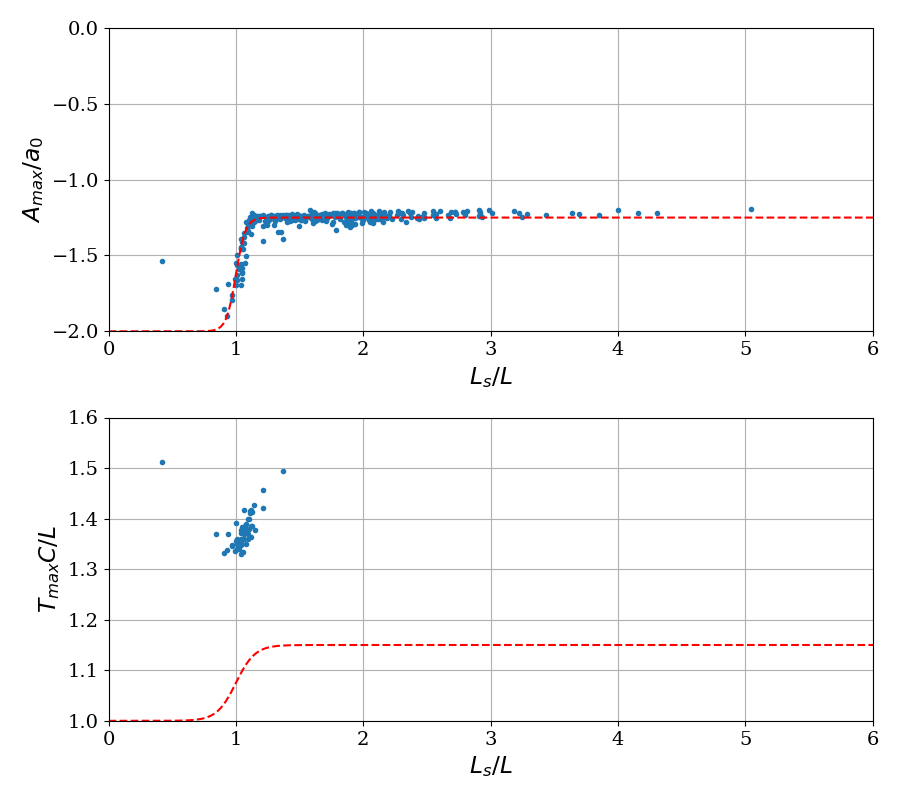

In [166]:
# Parametric form
def calc_Ahat(Lhat, Amax, A0, L0, dLA):
    #return dA*A0 + 0.5*dA*(1+np.tanh( (Lhat-L0)/dLA))
    #return A0*0.5*(2*dA + 1 + np.tanh( (Lhat-L0)/dLA))
    return -Amax + 0.5*(Amax-A0) * (1 + np.tanh( (Lhat-L0)/(0.5*dLA)) )


Lhat = np.linspace(0,10,500)
Ahat = calc_Ahat(Lhat, 2, 1.25, 1, 0.15)

That = calc_Ahat(Lhat, -1, -1.15, 1.0, 0.30)


plt.figure(figsize=(9,8))
plt.subplot(211)
plt.plot(Ls/x_pt, Amax/a0, '.')

plt.plot(Lhat, Ahat,'r--')

plt.grid(b=True)
plt.ylim(-2,0)
plt.xlim(0.,6)
plt.xlabel('$L_s/L$')
plt.ylabel('$A_{max}/a_0$')

plt.subplot(212)
#plt.plot(Ls/x_pt  , (Amax/a0) * (Tmax*C_x/x_pt) , '.')
plt.plot(Ls/x_pt  ,  (Tmax_norm*C_x/x_pt)*12.42*3600 , '.')
plt.plot(Lhat, That,'r--')

plt.grid(b=True)
plt.xlim(0.,6)
plt.ylim(1,1.6)
plt.xlabel('$L_s/L$')
plt.ylabel('$T_{max} C/L$')
plt.tight_layout()

plt.savefig('../FIGURES/Parametric_KDV_Prelude_topo.png',dpi=150)
plt.savefig('../FIGURES/Parametric_KDV_Prelude_topo.pdf',dpi=150)